In [1]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_26584/2174054843.py:8: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [3]:
%%R
library(tidyverse)
library(dyno)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: dynfeature
Loading required package: dynguidelines
Loading required package: dynmethods
Loading required package: dynplot
Loading required package: dynwrap
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [4]:
%%R
data <- readRDS("multifurcating_1.rds")

In [5]:
%%R
dpt_model <- infer_trajectory(data, ti_dpt(), give_priors = c("start_id"))

In [6]:
%%R
names(dpt_model)

 [1] "id"                          "cell_ids"                   
 [3] "cell_info"                   "group_ids"                  
 [5] "grouping"                    "milestone_ids"              
 [7] "milestone_network"           "divergence_regions"         
 [9] "milestone_percentages"       "progressions"               
[11] "trajectory_type"             "directed"                   
[13] "dimred"                      "dimred_projected"           
[15] "dimred_milestones"           "dimred_segment_progressions"
[17] "dimred_segment_points"      


In [7]:
%%R
library(dyneval)

In [8]:
%%R
dpt_model <- add_cell_waypoints(dpt_model, num_cells_selected = 100)
is_wrapper_with_waypoint_cells(dpt_model)

[1] TRUE


In [9]:
%%R
dpt_metrics <- calculate_metrics(
  dataset = data,
  model = dpt_model,
  expression_source = data$expression
)

In [10]:
%%R
names(dpt_metrics)

 [1] "time_waypointedgeodesic"    "correlation"               
 [3] "time_correlation"           "edge_flip"                 
 [5] "time_edge_flip"             "him"                       
 [7] "time_him"                   "isomorphic"                
 [9] "time_isomorphic"            "time_pp"                   
[11] "rf_mse"                     "rf_nmse"                   
[13] "rf_rsq"                     "lm_nmse"                   
[15] "lm_mse"                     "lm_rsq"                    
[17] "time_featureimp"            "featureimp_cor"            
[19] "featureimp_wcor"            "time_featureimp_enrichment"
[21] "featureimp_ks"              "featureimp_wilcox"         
[23] "time_mapping_branches"      "recovery_branches"         
[25] "relevance_branches"         "F1_branches"               
[27] "time_mapping_milestones"    "recovery_milestones"       
[29] "relevance_milestones"       "F1_milestones"             


In [11]:
%%R
cat("HIM =", dpt_metrics$him, "\n")
cat("F1_branches =", dpt_metrics$F1_branches, "\n")
cat("correlation =", dpt_metrics$correlation, "\n")
cat("featureimp_wcor =", dpt_metrics$featureimp_wcor, "\n")
selected_metrics <- c(
  him = as.numeric(dpt_metrics$him),
  F1_branches = dpt_metrics$F1_branches,
  correlation = dpt_metrics$correlation,
  featureimp_wcor = dpt_metrics$featureimp_wcor
)
overall_score <- exp(mean(log(selected_metrics)))
cat("overall_score =", overall_score, "\n")

HIM = 0.4689208 
F1_branches = 0.2949282 
correlation = 0.2556724 
featureimp_wcor = 0.8039331 
overall_score = 0.4106103 


In [12]:
%%R
library(dyndimred)
pca_dimred <- dimred_pca(
  data$expression
)

In [13]:
%%R
grouping <- data$grouping

Loading required namespace: RColorBrewer


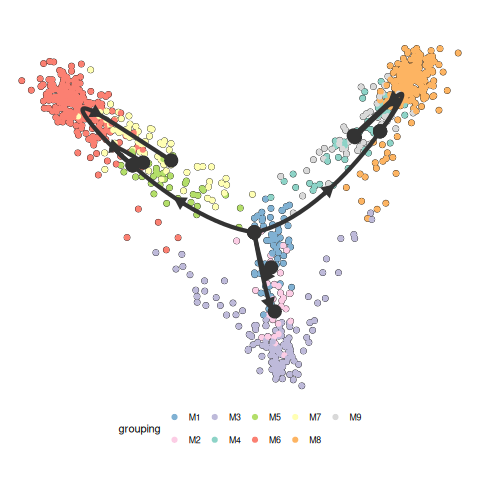

In [14]:
%%R
plot_dimred(data, dimred=pca_dimred, color_cells="grouping")

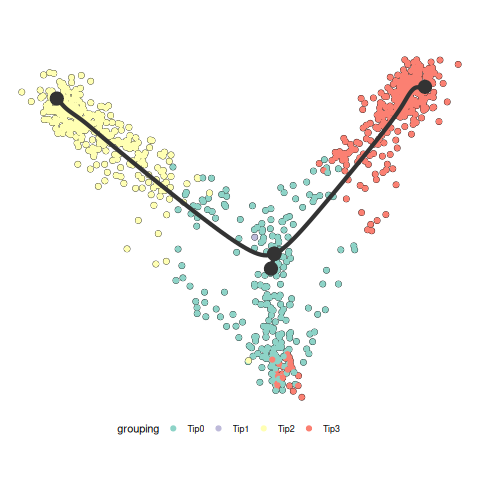

In [15]:
%%R
plot_dimred(dpt_model, dimred=pca_dimred, color_cells="grouping")

In [16]:
%%R
scorpius_model <- infer_trajectory(data, ti_scorpius(), give_priors = c("start_id"))

You can run this method as an R wrapper (1, default) or as a container (2)
Which do you want to use? This option will be saved in options(dynwrap_backend = c('r_wrapper', 'container'))
1: R wrapper [default]
2: Container
Following packages have to be installed: SCORPIUS
Do you want to install these packages? 
1: Yes [default]
2: No
Skipping install of 'SCORPIUS' from a github remote, the SHA1 (a0a97907) has not changed since last install.
  Use `force = TRUE` to force installation


In [17]:
%%R

scorpius_model <- add_cell_waypoints(scorpius_model)

scorpius_metrics <- calculate_metrics(
  dataset = data,
  model = scorpius_model,
  metrics = c("him", "F1_branches", "correlation", "featureimp_wcor"),
  expression_source = data$expression
)

In addition: Warning message:
`data_frame()` was deprecated in tibble 1.1.0.
ℹ Please use `tibble()` instead.
ℹ The deprecated feature was likely used in the dyneval package.
  Please report the issue to the authors.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


In [18]:
%%R
cat("HIM =", scorpius_metrics$him, "\n")
cat("F1_branches =", scorpius_metrics$F1_branches, "\n")
cat("correlation =", scorpius_metrics$correlation, "\n")
cat("featureimp_wcor =", scorpius_metrics$featureimp_wcor, "\n")
selected_metrics <- c(
  him = as.numeric(scorpius_metrics$him),
  F1_branches = scorpius_metrics$F1_branches,
  correlation = scorpius_metrics$correlation,
  featureimp_wcor = scorpius_metrics$featureimp_wcor
)
overall_score <- exp(mean(log(selected_metrics)))
cat("overall_score =", overall_score, "\n")

HIM = 0.3350716 
F1_branches = 0.1676218 
correlation = 0.7431764 
featureimp_wcor = 0.6874808 
overall_score = 0.4115808 


Coloring by milestone
Using milestone_percentages from trajectory


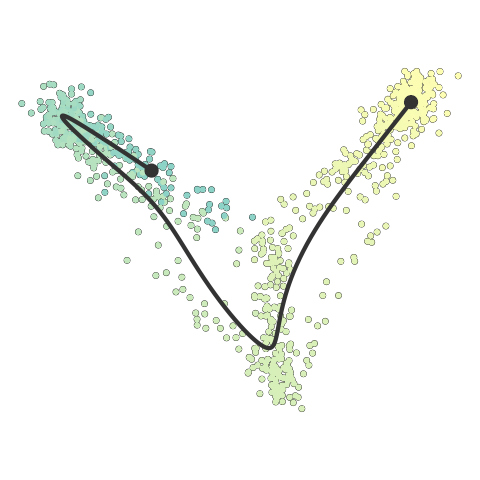

In [19]:
%%R
plot_dimred(scorpius_model, dimred=pca_dimred)

HIM = 0.2693585 
F1_branches = 0.1676218 
correlation = 0.6658283 
featureimp_wcor = 0.8228653 
overall_score = 0.3965866 


Coloring by milestone
Using milestone_percentages from trajectory


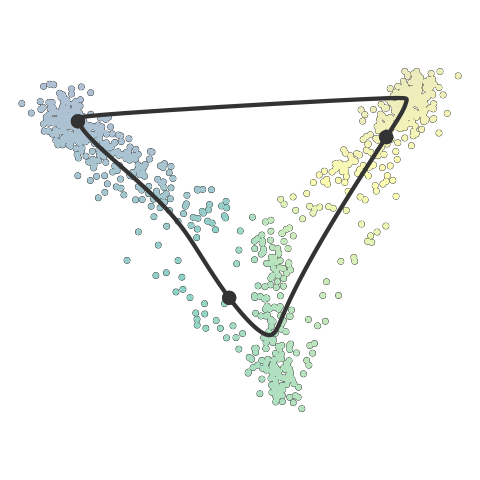

In [20]:
%%R
angle_model <- infer_trajectory(data, ti_angle(), give_priors = c("start_id"))
angle_model <- add_cell_waypoints(angle_model)
angle_metrics <- calculate_metrics(
  dataset = data,
  model = angle_model,
  metrics = c("him", "F1_branches", "correlation", "featureimp_wcor"),
  expression_source = data$expression
)
cat("HIM =", angle_metrics$him, "\n")
cat("F1_branches =", angle_metrics$F1_branches, "\n")
cat("correlation =", angle_metrics$correlation, "\n")
cat("featureimp_wcor =", angle_metrics$featureimp_wcor, "\n")
selected_metrics <- c(
  him = as.numeric(angle_metrics$him),
  F1_branches = angle_metrics$F1_branches,
  correlation = angle_metrics$correlation,
  featureimp_wcor = angle_metrics$featureimp_wcor
)
overall_score <- exp(mean(log(selected_metrics)))
cat("overall_score =", overall_score, "\n")
plot_dimred(angle_model, dimred=pca_dimred)

HIM = 0.7137153 
F1_branches = 0.4234074 
correlation = 0.5241862 
featureimp_wcor = 0.9103585 
overall_score = 0.6162336 


Coloring by milestone
Using milestone_percentages from trajectory


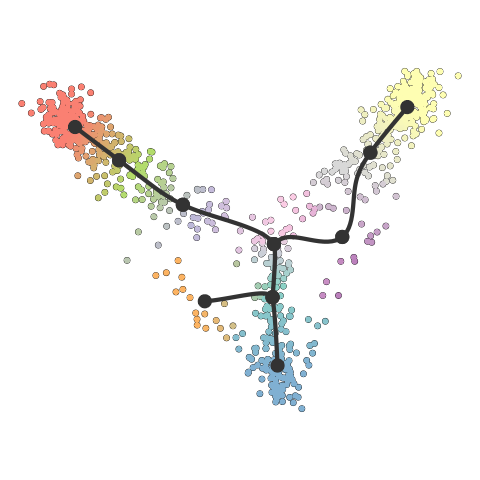

In [21]:
%%R
mst_model <- infer_trajectory(data, ti_mst(), give_priors = c("start_id"))
mst_model <- add_cell_waypoints(mst_model)
mst_metrics <- calculate_metrics(
  dataset = data,
  model = mst_model,
  metrics = c("him", "F1_branches", "correlation", "featureimp_wcor"),
  expression_source = data$expression
)
cat("HIM =", mst_metrics$him, "\n")
cat("F1_branches =", mst_metrics$F1_branches, "\n")
cat("correlation =", mst_metrics$correlation, "\n")
cat("featureimp_wcor =", mst_metrics$featureimp_wcor, "\n")
selected_metrics <- c(
  him = as.numeric(mst_metrics$him),
  F1_branches = mst_metrics$F1_branches,
  correlation = mst_metrics$correlation,
  featureimp_wcor = mst_metrics$featureimp_wcor
)
overall_score <- exp(mean(log(selected_metrics)))
cat("overall_score =", overall_score, "\n")
plot_dimred(mst_model, dimred=pca_dimred)

HIM = 0.3350716 
F1_branches = 0.1676218 
correlation = 0.5737883 
featureimp_wcor = 0.7190158 
overall_score = 0.3901571 


Coloring by milestone
Using milestone_percentages from trajectory


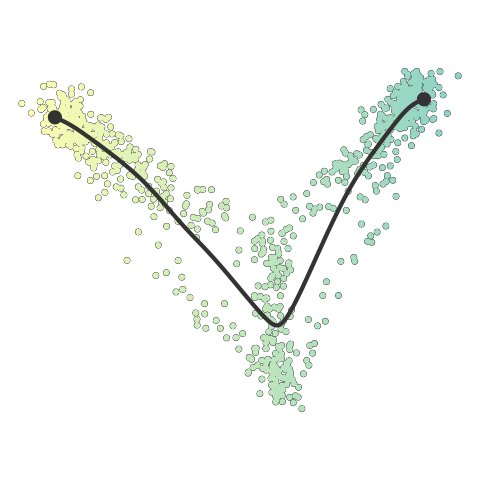

In [22]:
%%R
comp1_model <- infer_trajectory(data, ti_comp1(), give_priors = c("start_id"))
comp1_model <- add_cell_waypoints(comp1_model)
comp1_metrics <- calculate_metrics(
  dataset = data,
  model = comp1_model,
  metrics = c("him", "F1_branches", "correlation", "featureimp_wcor"),
  expression_source = data$expression
)
cat("HIM =", comp1_metrics$him, "\n")
cat("F1_branches =", comp1_metrics$F1_branches, "\n")
cat("correlation =", comp1_metrics$correlation, "\n")
cat("featureimp_wcor =", comp1_metrics$featureimp_wcor, "\n")
selected_metrics <- c(
  him = as.numeric(comp1_metrics$him),
  F1_branches = comp1_metrics$F1_branches,
  correlation = comp1_metrics$correlation,
  featureimp_wcor = comp1_metrics$featureimp_wcor
)
overall_score <- exp(mean(log(selected_metrics)))
cat("overall_score =", overall_score, "\n")
plot_dimred(comp1_model, dimred=pca_dimred)

### take multiple random networks and check if metrics' scores with ground truth are visibly correct

In [23]:
%%R
new_data <- wrap_expression(expression=data$expression, counts=data$counts)

In [24]:
%%R
data <- add_dimred(data,pca_dimred,connect_segments=TRUE,project_trajectory=TRUE)
names(data)

 [1] "id"                          "cell_ids"                   
 [3] "cell_info"                   "counts"                     
 [5] "expression"                  "feature_info"               
 [7] "milestone_ids"               "milestone_network"          
 [9] "divergence_regions"          "milestone_percentages"      
[11] "progressions"                "trajectory_type"            
[13] "prior_information"           "simulation_design"          
[15] "source"                      "waypoint_cells"             
[17] "directed"                    "dimred"                     
[19] "dimred_milestones"           "dimred_segment_progressions"
[21] "dimred_segment_points"      


In [25]:
%%R
print(data$dimred_milestones)

       comp_1      comp_2
M1  1.0074616 -5.25149318
M3  0.1785554 -3.54164549
M6 -5.7703075 -0.26002777
M8  6.3354131  1.40269146
M2  1.1840715 -7.40801647
M7 -3.8838287 -0.02091375
M5 -5.2555409 -0.12525350
M9  5.0459556  1.20113531
M4  5.1037561  1.11528269


In [26]:
%%R
#' Generate Random Milestone Networks with Distances
#'
#' Creates random networks similar to the original milestone_network,
#' with different edges between milestones. Also calculates the Euclidean
#' distance between connected milestones based on their coordinates.
#'
#' @param milestone_network A tibble with the original network structure
#' @param dimred_milestones A data frame with milestone coordinates
#' @param n_networks Number of random networks to generate
#'
#' @return A list of tibbles, each containing a random network with distances
#'
generate_random_milestone_networks <- function(milestone_network, dimred_milestones, n_networks = 10) {
  # Get all unique milestones
  all_milestones <- rownames(dimred_milestones)
  
  # Calculate Euclidean distance between two milestones
  calculate_distance <- function(m1, m2) {
    x1 <- dimred_milestones[m1, "comp_1"]
    y1 <- dimred_milestones[m1, "comp_2"]
    x2 <- dimred_milestones[m2, "comp_1"]
    y2 <- dimred_milestones[m2, "comp_2"]
    
    sqrt((x2 - x1)^2 + (y2 - y1)^2)
  }
  
  # Generate random networks
  random_networks <- list()
  
  for (i in 1:n_networks) {
    # Number of edges
    n_edges <- nrow(milestone_network)
    
    # Initialize tibble
    random_net <- tibble::tibble(
      from = character(n_edges),
      to = character(n_edges),
      length = numeric(n_edges),
      directed = rep(TRUE, n_edges),
    )
    
    # Generate random edges
    for (j in 1:n_edges) {
      # Select distinct from and to milestones
      repeat {
        from_node <- sample(all_milestones, 1)
        to_node <- sample(all_milestones, 1)
        if (from_node != to_node) break
      }
      
      # Assign to tibble
      random_net$from[j] <- from_node
      random_net$to[j] <- to_node
      random_net$length[j] <- calculate_distance(from_node, to_node)
    }
    
    random_networks[[i]] <- random_net
  }
  
  return(random_networks)
}


In [27]:
%%R
data$milestone_network

# A tibble: 8 × 4
  from  to    length directed
  <chr> <chr>  <dbl> <lgl>   
1 M1    M3     0.349 TRUE    
2 M3    M2     0.407 TRUE    
3 M6    M7     0.883 TRUE    
4 M3    M6     0.216 TRUE    
5 M6    M5     0.445 TRUE    
6 M8    M9     0.726 TRUE    
7 M3    M8     0.259 TRUE    
8 M8    M4     0.606 TRUE    


In [28]:
%%R
library(dynplot)

In [29]:
%%R
new_data <- add_grouping(new_data, data$grouping)
is_wrapper_with_grouping(new_data)

[1] TRUE


In [30]:
%%R
# Example usage with the provided data
random_networks <- generate_random_milestone_networks(
  data$milestone_network, 
  data$dimred_milestones, 
  n_networks = 10
)

# View the first random network
random_networks[[1]]


# A tibble: 8 × 4
  from  to    length directed
  <chr> <chr>  <dbl> <lgl>   
1 M3    M5      6.42 TRUE    
2 M9    M3      6.80 TRUE    
3 M8    M3      7.90 TRUE    
4 M5    M1      8.09 TRUE    
5 M1    M3      1.90 TRUE    
6 M4    M2      9.38 TRUE    
7 M9    M7      9.01 TRUE    
8 M4    M2      9.38 TRUE    


In [31]:
%%R
traj <- add_cluster_graph(new_data, random_networks[[1]], grouping=data$grouping, 
  color_cells = c("grouping"), color_milestones = c("rainbow"), plot_milestones=TRUE)
plot_graph(traj)

Error: !any(duplicated(milestone_network %>% select(from, to))) is not TRUE


RInterpreterError: Failed to parse and evaluate line 'traj <- add_cluster_graph(new_data, random_networks[[1]], grouping=data$grouping, \n  color_cells = c("grouping"), color_milestones = c("rainbow"), plot_milestones=TRUE)\nplot_graph(traj)\n'.
R error message: 'Error: !any(duplicated(milestone_network %>% select(from, to))) is not TRUE'

Coloring by milestone
Using milestone_percentages from trajectory


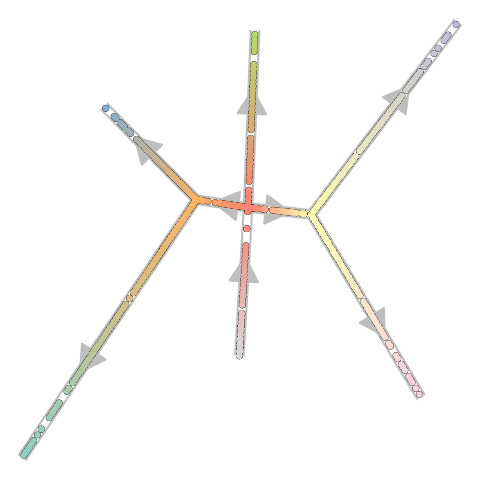

In [ ]:
%%R
plot_graph(data)

In [ ]:
%%R
new_metrics <- calculate_metrics(
  dataset = data,
  model = traj,
  metrics = "him",
)
print(new_metrics$him)

[1] 0


In [ ]:
%%R
names(traj)

 [1] "id"                    "cell_ids"              "cell_info"            
 [4] "feature_ids"           "feature_info"          "counts"               
 [7] "expression"            "expression_future"     "group_ids"            
[10] "grouping"              "milestone_ids"         "milestone_network"    
[13] "divergence_regions"    "milestone_percentages" "progressions"         
[16] "color_cells"           "color_milestones"      "plot_milestones"      
[19] "trajectory_type"       "directed"             
